<a href="https://colab.research.google.com/github/lucacerab/DSEthesis-transformers/blob/main/AM_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the argumentation mining pipeline on the essays dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from tensorflow import keras

model0 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/tesi/AM/binary/UKP_binary/UKP_binary_final/UKP_binary_finetuned/UKPentire_binary.h5')

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/essays.csv')
df

,essay,sentence,topic,label0,label1
0,essay01,It is always said that competition can effecti...,Should students be taught to compete or to coo...,Argument,Claim
1,essay01,"From this point of view, I firmly believe that...",Should students be taught to compete or to coo...,Argument,MajorClaim
2,essay01,"In order to survive in the competition, compan...",Should students be taught to compete or to coo...,Argument,Premise
3,essay01,"First of all, through cooperation, children ca...",Should students be taught to compete or to coo...,Argument,Claim
4,essay01,What we acquired from team work is not only ho...,Should students be taught to compete or to coo...,Argument,Premise
...,...,...,...,...,...
1668,essay90,As companies and factories move to the country...,Solve traffic and housing problems by moving c...,Argument,Premise
1669,essay90,This can be best illustrated with the example ...,Solve traffic and housing problems by moving c...,Argument,Premise
1670,essay90,Solve traffic and housing problems by moving c...,Solve traffic and housing problems by moving c...,NoArgument,NoArgument
1671,essay90,With the booming development of some cosmopoli...,Solve traffic and housing problems by moving c...,NoArgument,NoArgument


In [ ]:
df.groupby('label1')['essay'].count()

label1
Claim         419
MajorClaim     88
NoArgument    333
Premise       833
Name: essay, dtype: int64

In [ ]:
# merge claims and major claims 
df.loc[df.label1 == 'MajorClaim', 'label1'] = 'Claim'

In [ ]:
df.groupby('label1')['essay'].count()

label1
Claim         507
NoArgument    333
Premise       833
Name: essay, dtype: int64

In [ ]:
'''df['new_label0'] = [0 if ele == 'NoArgument' else 1 for ele in df['label0']]
essays = df[['topic', 'sentence', 'new_label0', 'label1']].copy()
essays.rename(columns={'new_label0':'label0'}, inplace=True)'''

In [ ]:
df = df.sample(frac=1, random_state=123).reset_index(drop=True)
df.head()

,essay,sentence,topic,label0,label1
0,essay66,"Thus, every country has been promoting technol...",Technology keeps traditional skills and ways o...,NoArgument,NoArgument
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise
2,essay62,"Women like Margaret Thatcher, Indira Gandhi, M...",should universities accept equal number of mal...,Argument,Premise
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
import numpy as np

def bert_encode(df, max_len):
  num_samples = len(df)

  X_ids = np.zeros((num_samples, max_len))
  X_mask = np.zeros((num_samples, max_len))
  X_type_ids = np.zeros((num_samples, max_len))
  

  for i, row in df.iterrows():
      encoded = tokenizer.encode_plus(row['topic'], row['sentence'], max_length=max_len,
                                      truncation=True, padding='max_length', add_special_tokens=True)    
      X_ids[i, :] = encoded['input_ids']
      X_mask[i, :] = encoded['attention_mask'] 
      X_type_ids[i, :] = encoded['token_type_ids'] 
  return X_ids, X_mask, X_type_ids

In [ ]:
max_len = 128

In [ ]:
essays_input_ids, essays_attention_masks, essays_token_type_ids = bert_encode(df, max_len)

In [ ]:
tokenizer.decode(essays_input_ids[0])

'[CLS] Technology keeps traditional skills and ways of life alive or not? [SEP] Thus, every country has been promoting technological advances in the recent years, regardless of any potential problems it may bring about. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
results0 = model0.predict([essays_input_ids, essays_attention_masks, essays_token_type_ids])

In [ ]:
preds0 = np.round(results0).astype(int)

In [ ]:
df['preds0'] = preds0
df.head()

,essay,sentence,topic,label0,label1,preds0
0,essay66,"Thus, every country has been promoting technol...",Technology keeps traditional skills and ways o...,NoArgument,NoArgument,0
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise,1
2,essay62,"Women like Margaret Thatcher, Indira Gandhi, M...",should universities accept equal number of mal...,Argument,Premise,0
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument,1
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim,1


In [ ]:
df['new_preds0'] = ['NoArgument' if ele == 0 else 'Argument' for ele in df['preds0']]

In [ ]:
df = df.drop('preds0', axis=1).reset_index(drop=True).rename(columns={'new_preds0': 'preds0'})
df

,essay,sentence,topic,label0,label1,preds0
0,essay66,"Thus, every country has been promoting technol...",Technology keeps traditional skills and ways o...,NoArgument,NoArgument,NoArgument
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise,Argument
2,essay62,"Women like Margaret Thatcher, Indira Gandhi, M...",should universities accept equal number of mal...,Argument,Premise,NoArgument
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument,Argument
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim,Argument
...,...,...,...,...,...,...
1668,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...,Argument,Claim,Argument
1669,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?,Argument,Premise,Argument
1670,essay77,"In order to protect animals, from my perspecti...",zoos should be banned,Argument,Claim,Argument
1671,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?,Argument,Premise,Argument


In [ ]:
from sklearn.metrics import classification_report

#target_names = ['NoArg', 'Arg']
print(classification_report(df.label0, df.preds0))

              precision    recall  f1-score   support

    Argument       0.88      0.67      0.76      1340
  NoArgument       0.33      0.65      0.43       333

    accuracy                           0.66      1673
   macro avg       0.60      0.66      0.60      1673
weighted avg       0.77      0.66      0.69      1673



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

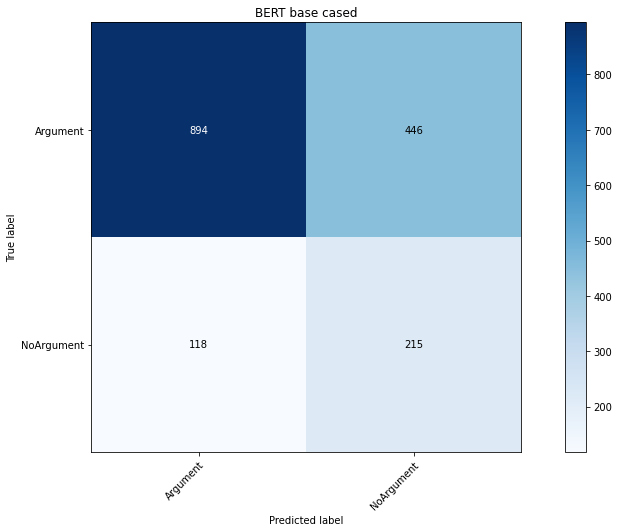

In [ ]:
classes = ['Argument', 'NoArgument']
plot_confusion_matrix(df.label0, df.preds0, classes=classes, normalize=False, title='BERT base cased')
plt.show()

In [ ]:
df

,essay,sentence,topic,label0,label1,preds0
0,essay66,"Thus, every country has been promoting technol...",Technology keeps traditional skills and ways o...,NoArgument,NoArgument,NoArgument
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise,Argument
2,essay62,"Women like Margaret Thatcher, Indira Gandhi, M...",should universities accept equal number of mal...,Argument,Premise,NoArgument
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument,Argument
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim,Argument
...,...,...,...,...,...,...
1668,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...,Argument,Claim,Argument
1669,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?,Argument,Premise,Argument
1670,essay77,"In order to protect animals, from my perspecti...",zoos should be banned,Argument,Claim,Argument
1671,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?,Argument,Premise,Argument


In [ ]:
args = df[df['preds0'] == 'Argument'].reset_index(drop=True)

In [ ]:
args = args[['essay', 'sentence', 'topic']].copy()
args

,essay,sentence,topic
0,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission
1,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis
2,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?
3,essay04,"Take Thailand for example, in the Vietnam War,...",International tourism is now more common than ...
4,essay30,"Furthermore, this will encourage all the paren...",Government And Education
...,...,...,...
1007,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...
1008,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?
1009,essay77,"In order to protect animals, from my perspecti...",zoos should be banned
1010,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?


In [ ]:
model1 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/tesi/AM/subjectivity/SUBJ_final.h5')

In [ ]:
args_input_ids, args_attention_masks, _ = bert_encode(args, max_len)

In [ ]:
tokenizer.decode(args_input_ids[0])

'[CLS] Gender Equality at university admission [SEP] Initially, if we look into the fact, women have proved themselves in every field whether it is indoor or outdoor. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
results1 = model1.predict([args_input_ids, args_attention_masks])

In [ ]:
preds1 = np.round(results1).astype(int)

In [ ]:
args['preds1'] = preds1
args.head()

,essay,sentence,topic,preds1
0,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,0
1,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,0
2,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,0
3,essay04,"Take Thailand for example, in the Vietnam War,...",International tourism is now more common than ...,0
4,essay30,"Furthermore, this will encourage all the paren...",Government And Education,0


In [ ]:
args['new_preds1'] = ['Claim' if ele == 0 else 'Premise' for ele in args['preds1']]

In [ ]:
args = args.drop('preds1', axis=1).reset_index(drop=True).rename(columns={'new_preds1': 'preds1'})
args

,essay,sentence,topic,preds1
0,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Claim
1,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,Claim
2,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Claim
3,essay04,"Take Thailand for example, in the Vietnam War,...",International tourism is now more common than ...,Claim
4,essay30,"Furthermore, this will encourage all the paren...",Government And Education,Claim
...,...,...,...,...
1007,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...,Claim
1008,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?,Claim
1009,essay77,"In order to protect animals, from my perspecti...",zoos should be banned,Claim
1010,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?,Claim


In [ ]:
args.groupby('preds1')['essay'].count()

preds1
Claim      909
Premise    103
Name: essay, dtype: int64

In [ ]:
comb = pd.merge(df, args, on=['essay', 'sentence', 'topic'], how='left')

In [ ]:
comb

,essay,sentence,topic,label0,label1,preds0,preds1
0,essay66,"Thus, every country has been promoting technol...",Technology keeps traditional skills and ways o...,NoArgument,NoArgument,NoArgument,NaN
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise,Argument,Claim
2,essay62,"Women like Margaret Thatcher, Indira Gandhi, M...",should universities accept equal number of mal...,Argument,Premise,NoArgument,NaN
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument,Argument,Claim
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim,Argument,Claim
...,...,...,...,...,...,...,...
1668,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...,Argument,Claim,Argument,Claim
1669,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?,Argument,Premise,Argument,Claim
1670,essay77,"In order to protect animals, from my perspecti...",zoos should be banned,Argument,Claim,Argument,Claim
1671,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?,Argument,Premise,Argument,Claim


In [ ]:
comb.preds1 = comb.preds1.fillna('NoArgument')

In [ ]:
comb

,essay,sentence,topic,label0,label1,preds0,preds1
0,essay66,"Thus, every country has been promoting technol...",Technology keeps traditional skills and ways o...,NoArgument,NoArgument,NoArgument,NoArgument
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise,Argument,Claim
2,essay62,"Women like Margaret Thatcher, Indira Gandhi, M...",should universities accept equal number of mal...,Argument,Premise,NoArgument,NoArgument
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument,Argument,Claim
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim,Argument,Claim
...,...,...,...,...,...,...,...
1668,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...,Argument,Claim,Argument,Claim
1669,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?,Argument,Premise,Argument,Claim
1670,essay77,"In order to protect animals, from my perspecti...",zoos should be banned,Argument,Claim,Argument,Claim
1671,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?,Argument,Premise,Argument,Claim


In [ ]:
from sklearn.metrics import classification_report

#target_names = ['NoArg', 'Arg']
print(classification_report(comb.label1, comb.preds1))

              precision    recall  f1-score   support

       Claim       0.37      0.66      0.47       507
  NoArgument       0.33      0.65      0.43       333
     Premise       0.47      0.06      0.10       833

    accuracy                           0.36      1673
   macro avg       0.39      0.45      0.34      1673
weighted avg       0.41      0.36      0.28      1673



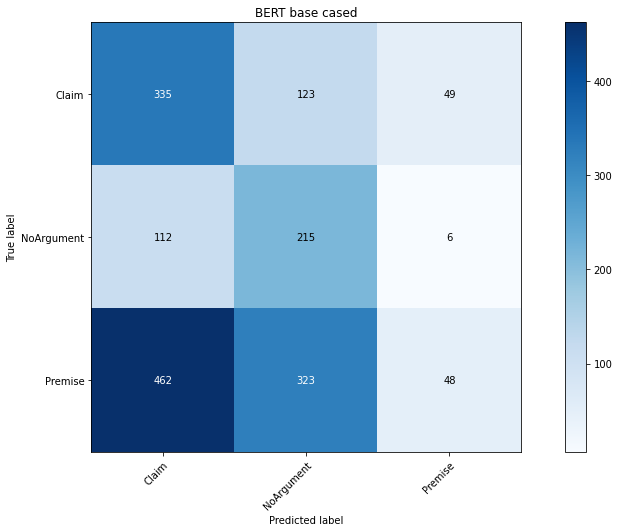

In [ ]:
classes = ['Claim', 'NoArgument', 'Premise']
plot_confusion_matrix(comb.label1, comb.preds1, classes=classes, normalize=False, title='BERT base cased')
plt.show()

In [ ]:
comb[comb['preds1'] == 'Claim']

,essay,sentence,topic,label0,label1,preds0,preds1
1,essay18,"Initially, if we look into the fact, women hav...",Gender Equality at university admission,Argument,Premise,Argument,Claim
3,essay09,"Cannabis is classified as a schedule one drug,...",The Truth About Cannabis,NoArgument,NoArgument,Argument,Claim
4,essay39,"Finally, a great deal of sophisticated technol...",Why should human beings travel to outer space?,Argument,Claim,Argument,Claim
5,essay04,"Take Thailand for example, in the Vietnam War,...",International tourism is now more common than ...,Argument,Premise,Argument,Claim
7,essay30,"Furthermore, this will encourage all the paren...",Government And Education,Argument,Claim,Argument,Claim
...,...,...,...,...,...,...,...
1668,essay60,A break gives students more benefits than harms.,is a break good or bad after high school for s...,Argument,Claim,Argument,Claim
1669,essay73,"Nevertheless, the importance of written word c...",Is image more powerful than the written word?,Argument,Premise,Argument,Claim
1670,essay77,"In order to protect animals, from my perspecti...",zoos should be banned,Argument,Claim,Argument,Claim
1671,essay75,This is simply because knowledge and wisdom is...,Do arts and music improve the quality of life?,Argument,Premise,Argument,Claim


In [ ]:
comb.loc[5]

essay                                                 essay04
sentence    Take Thailand for example, in the Vietnam War,...
topic       International tourism is now more common than ...
label0                                               Argument
label1                                                Premise
preds0                                               Argument
preds1                                                  Claim
Name: 5, dtype: object

In [ ]:
comb.loc[5].sentence

'Take Thailand for example, in the Vietnam War, many American soldiers came to Thailand for a break and involved in sexual and drug activities, these huge demands caused many local businesses opened and expanded, even illegally involved in under-age prostitutes to maximise their profits.'

In [ ]:
comb.loc[1669]

essay                                                 essay73
sentence    Nevertheless, the importance of written word c...
topic           Is image more powerful than the written word?
label0                                               Argument
label1                                                Premise
preds0                                               Argument
preds1                                                  Claim
Name: 1669, dtype: object

In [ ]:
comb.loc[1669].sentence

'Nevertheless, the importance of written word can never be denied as it is also another way of communication that is commonly used.'